# **Αναγνώριση Προτύπων**


**1η Εργαστηριακή Άσκηση**

**Οπτική Αναγνώριση Ψηφίων**

# Παρατηρήσεις:

* Πιθανώς να χρειαστεί upgrade στις απαιτούμες βιβλιοθήκες, προκειμένου να τρέξει ο κώδικας.

In [1]:
!pip3 install --upgrade pip #upgrade pip package installer
!pip3 install scikit-learn --upgrade #upgrade scikit-learn package
!pip3 install --user numpy --upgrade #upgrade numpy package

Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages (18.1)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.5/dist-packages (0.20.0)
Requirement already up-to-date: numpy in /home/nikol/.local/lib/python3.5/site-packages (1.15.3)


* Δηλώνονται οι απαιτούμενες βιβλιοθήκες.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import math

from scipy.spatial import distance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import VotingClassifier, BaggingClassifier

* Euclidean distance classifier implemented as scikit-learn estimator
Used in STEP 12,13

In [3]:
class EuclideanClassifier(BaseEstimator, ClassifierMixin):
    """Classify samples based on the distance from the mean feature value"""
    def __init__(self):
        self.X_mean_ = None

    def fit(self, X, y):
        """ Calculates self.X_mean_ based on the mean
        feature values in X for each class. """
        mean_pixels_d = [None] * 10
        var_pixels_d = [None] * 10
        for label in range(0,10):
            indices_d = [i for i, x in enumerate(y) if x == label]
            pixels_d = []
            for i in indices_d:
                pixels_d.append(X[i,:])
            mean_pixels_d[label] = np.mean(pixels_d,axis=0)
        mean_pixels_d = np.reshape(mean_pixels_d, (10,X.shape[1]))
        self.X_mean_ = mean_pixels_d
        return self

    def predict(self, X):
        """ Make predictions for X based on the
        euclidean distance from self.X_mean_ """
        len_samples = X.shape[0]
        len_features = X.shape[1]
        mean_pixels_d = self.X_mean_[:,0:len_features]
        digit_matched = [None] * len_samples
        for i in range(0,len_samples):
            features_d = X[i,:]
            eudist_d_all = []
            for label in range(0,10):
                eudist_d = distance.euclidean(features_d, mean_pixels_d[label])
                eudist_d_all.append(eudist_d)
            digit_matched[i] = float(np.argmin(eudist_d_all))
        digit_matched = np.asarray(digit_matched)
        return digit_matched

    def score(self, X, y):
        """ Return accuracy score on the predictions
        for X based on ground truth y """
        digit_matched = self.predict(X)
        len_samples = X.shape[0]
        hits_clas = 0
        for i in range(0,len_samples):
            hits_clas = hits_clas + (digit_matched[i] == y[i])
            srate_eudist = hits_clas / len_samples
        return srate_eudist


* Naive Bayes classifier implemented as scikit-learn estimator Used in STEPS 15, 16

In [4]:
# Naive Bayes classifier implemented as scikit-learn estimator
class BayesClassifier(BaseEstimator, ClassifierMixin):
    """Classify samples based on Gaussian naive bayes"""
    def __init__(self):
        self.X_mean_ = None
        self.X_var_ = None
        self.X_apriori_ = None

    def fit(self, X, y, v):
        """ Calculates self.X_mean_,self.X_var_ based on the mean and variance
        feature values in X for each class. Also calculates a priori probabilities self.X_apriori_ of digits 0-9."""
        mean_pixels_d = [None] * 10
        if v == 0:
            var_pixels_d = [None] * 10
        else:
            var_pixels_d = np.ones((10,X.shape[1]))

        for label in range(0,10):
            indices_d = [i for i, x in enumerate(y) if x == label]
            pixels_d = []
            for i in indices_d:
                pixels_d.append(X[i,:])
            mean_pixels_d[label] = np.mean(pixels_d,axis=0)
            if v==0:
                var_pixels_d[label] = np.var(pixels_d,axis=0)

        mean_pixels_d = np.reshape(mean_pixels_d, (10,X.shape[1]))
        var_pixels_d = np.reshape(var_pixels_d, (10,X.shape[1]))
        self.X_mean_ = mean_pixels_d
        self.X_var_ = var_pixels_d
        
        frequencies = np.bincount(y_train.astype(int))
        self.X_apriori_ = np.divide(frequencies,y_train.shape[0])
        return self

    def calcGaussian(self,x,mean,var):
        a = np.power(np.subtract(x,mean),2)
        b = np.multiply(var,2)
        c = np.divide(np.multiply(a,-1),b)
        c = np.exp(c)
        d = np.multiply(var,2*math.pi)
        d = np.power(d,1/2)
        e = np.divide(c,d)
        return e

    def predict(self, X):
        """ Make predictions for X based on Gaussian probability
        with self.X_mean_ and self.X_var_"""
        len_samples = X.shape[0]
        len_features = X.shape[1]
        mean_pixels_d = self.X_mean_[:,0:len_features]
        var_pixels_d = self.X_var_[:,0:len_features]
        digit_matched = [None] * len_samples
        for i in range(0,len_samples):
            features_d = X_test[i,:]
            prob = []
            for label in range(0,10):
                mean = mean_pixels_d[label]
                var = var_pixels_d[label]

                indices_var0 = [j for j, x in enumerate(var_pixels_d[label]) if x == 0]
                mean = np.delete(mean,indices_var0)
                var = np.delete(var,indices_var0)
                features = np.delete(features_d,indices_var0)

                prob_d = np.prod(self.calcGaussian(features,mean,var)) * self.X_apriori_[label]
                prob.append(prob_d)
            digit_matched[i] = float(np.argmax(prob))
        digit_matched = np.asarray(digit_matched)
        return digit_matched

    def score(self, X, y):
        """ Return accuracy score on the predictions
        for X based on ground truth y """
        digit_matched = self.predict(X)
        len_samples = X.shape[0]
        hits_clas = 0
        for i in range(0,len_samples):
            hits_clas = hits_clas + (digit_matched[i] == y[i])
            srate_eudist = hits_clas / len_samples
        return srate_eudist

# ** MAIN PROGRAM STARTS HERE **
*Απαιτείται η εκτέλεση του κώδικα στις **Παρατηρήσεις**, ώστε να είναι δυνατή η εκτέλεση του κυρίως προγράμματος*

# STEP 1

Πραγματοποιείται η ανάγνωση των δεδομένων από τα αρχεία train.txt, test.txt του φακέλου pr_lab1_2016_2017_data με τη χρήση της np.loadtxt() με όρισμα το path κάθε αρχείου txt και δημιουργούνται οι numpy arrays train_set, test_set. Στη συνέχεια δημιουργούνται οι numpy arrays X_train (train_set[:,1:] - δείγματα εκπαίδευσης χωρίς τα labels), y_train (train_set[:,0] - αντίστοιχα labels για τον X_train) και X_test, y_test ομοίως.

In [5]:
# load the txt files into 2D arrays using np library
train_set = np.loadtxt('train.txt')
test_set = np.loadtxt('test.txt')

# create X_train, y_train arrays
X_train = train_set[:,1:]
y_train = train_set[:,0]

# create X_test, y_test arrays
X_test = test_set[:,1:]
y_test = test_set[:,0]

# STEP 2
Λαμβάνονται τα χαρακτηριστικά του δείγματος που βρίσκεται στη θέση 131 των train δεδομένων (ως X_train[131,:]) και με τη συνάρτηση np.reshape() και διαστάσεις (16,16) μετασχηματίζεται καταλλήλως ο πίνακας χαρακτηριστικών για να εμφανιστεί με την συνάρτηση plt.imshow().

Το αποτέλεσμα εμφανίζεται στην παρακάτω εικόνα.

Όπως παρατηρούμε αντιστοιχεί στο ψηφίο 9 το οποίο συμπίπτει και με την ετικέτα του.



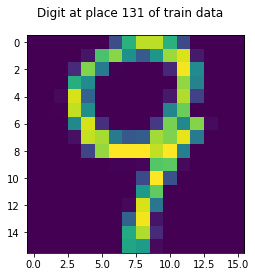

In [6]:
# take the features of the digit 131 - row 131 in X_train
features_131 = X_train[131,:]
features_131 = np.reshape(features_131, (16,16))

fig = plt.figure(1)
plt.imshow(features_131)
fig.suptitle('Digit at place 131 of train data')

plt.show()

# STEP 3

Επιλέγεται 1 τυχαίο δείγμα από κάθε label συνολικά για τα 10 δείγματα με τη συνάρτηση random.randint() και κατάλληλους ελέγχους και σχεδιάζονται όλα μαζί ακολουθώντας της διαδικασία του βήματος 2 (μετασχηματισμός σε μορφή (16,16)) σε ένα figure με subplots. Για το σκοπό αυτό υλοποιείται και καλείται η συνάρτηση subplt_samples_all(rsample) η οποία λαμβάνει ως όρισμα μια λίστα με στοιχεία τους numpy πίνακες χαρακτηριστικών σε διαστάσεις (16,16) και εμφανίζει καταλλήλως τις εικόνες των ψηφίων με τη χρήση των συναρτήσεων fig.add_subplot(), plt.imshow() με fig = plt.figure().

Το αποτέλεσμα εμφανίζεται στην παρακάτω εικόνα.



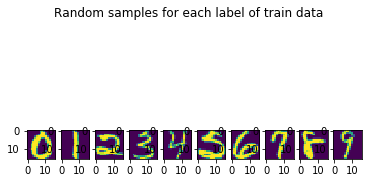

In [7]:
#function that takes the arrays of features for each digit and subplots them

def subplt_samples_all (rsample):
    for i in range(0,10):
        fig.add_subplot(1,10,i+1)
        plt.imshow(rsample[i])
    return

# select random sample for each label
rsample = [None] * 10
rsample_flag = [False] * 10

for i in range (0,10):
	size_train = len(X_train)
	x = random.randint(0,size_train)
	y = int(y_train[x])
	while rsample_flag[y]:
		x = random.randint(0,size_train)
		y = int(y_train[x])
	rsample_flag[y] = True	
	rsample[y] = np.reshape(X_train[x,:], (16,16))

fig = plt.figure(2)
subplt_samples_all (rsample)
fig.suptitle('Random samples for each label of train data')

plt.show()

# STEP 4

Για να υπολογίσουμε τη μέση τιμή των χαρακτηριστικών του pixel (10, 10) για το ψηφίο «0» με βάση τα train δεδομένα, υπολογίζουμε καταρχήν από τον y_train με τη συνάρτηση enumerate() τις θέσεις των δειγμάτων με label 0 (αποθηκεύονται στη λίστα indices_0).  Για καθένα από τα δείγματα που βρήκαμε παίρνουμε την τιμή του pixel (10,10) αφού μετασχηματίσουμε τον πίνακα σε διαστάσεις (16,16). Οι τιμές αυτές αποθηκεύονται σε μια λίστα (pixels10_d0) και κατόπιν με τη χρήση της συνάρτησης np.mean() επιστρέφεται η μέση τους τιμή. 

Η μέση τιμή του pixel (10, 10) για το ψηφίο «0» που εμφανίζεται είναι:

`Mean value of features of pixel(10,10) for digit 0 is -0.5041884422110553`


In [8]:
# mean value of pixel(10,10) for digit 0 in train set
pixels10_d0 = []
indices_0 = [i for i, x in enumerate(y_train) if x == 0]
for i in indices_0:
    pixels10_d0.append(np.reshape(X_train[i,:], (16,16))[10,10])

mean_pixel10_d0 = np.mean(pixels10_d0)
print("Mean value of features of pixel(10,10) for digit 0 is",mean_pixel10_d0)

Mean value of features of pixel(10,10) for digit 0 is -0.504188442211


# STEP 5

Στο βήμα αυτό ακολουθείται ακριβώς η ίδια διαδικασία με το βήμα 4, με τη διαφορά ότι στις τελικές τιμές που επιλέγονται για το pixel(10,10) υπολογίζεται η διασπορά. Συγκεκριμένα, στις τιμές τις λίστας (pixels10_d0) που δημιουργείται στο προηγούμενο ερώτημα εφαρμόζεται η συνάρτηση np.var() η οποία υπολογίζει τη διασπορά.

Η διασπορά του pixel (10, 10) για το ψηφίο «0» που εμφανίζεται είναι:

`Variance of features of pixel(10,10) for digit 0 is 0.5245221428814929`


In [9]:
# variance of pixel(10,10) for digit 0 in train set
var_pixel10_d0 = np.var(pixels10_d0)
print("Variance of features of pixel(10,10) for digit 0 is",var_pixel10_d0)


Variance of features of pixel(10,10) for digit 0 is 0.524522142881


# STEP 6

Για τον υπολογισμό της μέσης τιμής και διασποράς των χαρακτηριστικών κάθε pixel για το ψηφίο «0» με βάση τα train δεδομένα υλοποιείται η συνάρτηση mv_var_digit (indices_d) η οποία λαμβάνει ως είσοδο τις θέσεις εμφάνισης ενός συγκεκριμένου ψηφίου (0-10) στον πίνακα X_train και επιστρέφει τις μέσες τιμές και διασπορές των χαρακτηριστικών του σε μορφή numpy πινάκων με διαστάσεις (16,16). Στο εσωτερικό της συνάρτησης ακολουθείται η ίδια διαδικασία για τον υπολογισμό της μέσης τιμής, διασποράς που ακολουθήθηκε στα βήματα 5,6 με τη διαφορά ότι δεν επιλέγεται 1 pixel για κάθε δείγμα αλλά το σύνολο των χαρακτηριστικών του. Αυτό έχει ως αποτέλεσμα να δημιουργείται μια λίστα (pixels_d) με στοιχεία τους numpy πίνακες χαρακτηριστικών διαστάσεων (16,16). Στη λίστα αυτή εφαρμόζονται με την ίδια λογική οι συναρτήσεις np.mean(), np.var() με παράμετρο axis = 0 για να υπολογιστεί μέση τιμή, διασπορά των χαρακτηριστικών κάθε pixel. Έτσι επιστρέφονται οι πίνακες (16,16) mean_pixels_d, var_pixels_d που χρησιμοποιούνται στη συνέχεια.


In [10]:
#function that takes the indices of appareance of a digit and returns the mean value and variance of all pixels for the digit in train set

def mv_var_digit (indices_d):
    pixels_d = []
    for i in indices_d:
        pixels_d.append(np.reshape(X_train[i,:], (16,16)))
    mean_pixels_d = np.mean(pixels_d,axis=0)
    var_pixels_d = np.var(pixels_d,axis=0)
    return (mean_pixels_d,var_pixels_d)

  # mean value and variance of all pixels for digit 0 in train set
(mean_pixels_d0,var_pixels_d0) = mv_var_digit(indices_0)
#print("Mean value of features of all pixels for digit 0 is",mean_pixels_d0)
#print("Variance of features of all pixels for digit 0 is",var_pixels_d0)


# STEP 7

Ο πίνακας με τις μέσες τιμές των χαρακτηριστικών κάθε pixel για το ψηφίο «0» με βάση τα train δεδομένα που υπολογίστηκε στο βήμα 6, χρησιμοποιείται  για το σχεδιασμό του «0» με τη συνάρτηση plt.imshow().

Το αποτέλεσμα εμφανίζεται στην παρακάτω εικόνα.


Παρατηρούμε ότι εμφανίζεται αρκετά ξεκάθαρα το ψηφίο 0. Αυτό οφείλεται στο ότι παίρνοντας την μέση τιμή κάθε pixel έχουμε ως αποτέλεσμα ορισμένες ατέλειες δειγμάτων να εξαλείφονται και να τονίζονται περισσότερο περιοχές που περιλαμβάνονται στα περισσότερα δείγματα του dataset - αντιστοιχούν δηλαδή στα πιο συνηθισμένα γραμμένα στο χέρι μηδενικά. Επίσης, παρατηρούμε ότι σε ορισμένες περιοχές εμφανίζεται blurring ενώ άλλες είναι πιο φωτεινές γεγονός που σημαίνει ότι σε αυτές οι μέσες τιμές των χαρακτηριστικών ήταν μικρότερες και μεγαλύτερες αντίστοιχα.

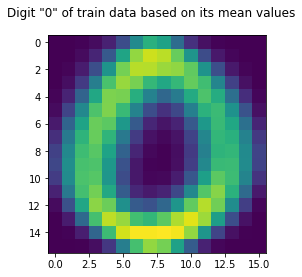

In [11]:
# draw digit 0 using the mean value of each pixel

fig = plt.figure(3)
plt.imshow(mean_pixels_d0)
fig.suptitle('Digit "0" of train data based on its mean values')

plt.show()

# STEP 8
Ο πίνακας με τις διασπορές των χαρακτηριστικών κάθε pixel για το ψηφίο «0» με βάση τα train δεδομένα που υπολογίστηκε στο βήμα 6, χρησιμοποιείται  για το σχεδιασμό του «0» με τη συνάρτηση plt.imshow().

Το αποτέλεσμα εμφανίζεται στην παρακάτω εικόνα.

Και εδώ το ψηφίο 0 είναι αναγνωρίσιμο ωστόσο παρατηρούμε ότι έχει τονιστεί πιο φωτεινά η περιοχή εσωτερικά και εξωτερικά του περιγράμματός του και λιγότερο η ενδιάμεση περιοχή. Στην περιοχή των 2 περιγραμμάτων που είναι πιο φωτεινή έχουμε μεγαλύτερη διασπορά γεγονός που σημαίνει ότι τα χαρακτηριστικά των δειγμάτων διέφεραν περισσότερο σε αυτές τις περιοχές (λιγότερα μηδενικά σχεδιάστηκαν σε αυτές), ενώ στην ενδιάμεση περιοχή διέφεραν λιγότερο (δηλαδή περισσότερα μηδενικά είχαν σχεδιαστεί με περίγραμμα σε αυτή). Αντίστοιχα, στο κέντρο του μηδενικού και στις γωνίες η διασπορά είναι πάρα πολύ μικρή, γιατί δεν υπήρχαν σχέδια σε αυτές γεγονός που προσδίδει περισσότερη ομοιομορφία. Παρατηρούμε ότι παρουσιάζονται αρκετές διαφορές στη συμπεριφορά της διασποράς και της μέσης τιμής, όπως αναλύθηκε παραπάνω.

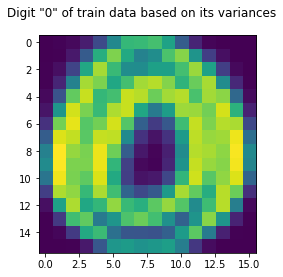

In [12]:
# draw digit 0 using the variance of each pixel

fig = plt.figure(4)
plt.imshow(var_pixels_d0)
fig.suptitle('Digit "0" of train data based on its variances')

plt.show()

# STEP 9
Για τον υπολογισμό της μέσης τιμής και διασποράς των χαρακτηριστικών για όλα τα ψηφία (0-9) με βάση τα train δεδομένα θα γενικεύσουμε τη διαδικασία που υλοποιήσαμε στο Βήμα 6 για τον υπολογισμό της μέσης τιμής και διασποράς των χαρακτηριστικών κάθε pixel για τις θέσεις εμφάνισης ενός συγκεκριμένου ψηφίου μέσω της συνάρτησης  mv_var_digit (indices_d). Για το σκοπό αυτό υλοποιούμε της συνάρτηση mv_var_all_digits (y_train) η οποία για κάθε είδος ψηφίου (0-9) που εμφανίζεται στον y_train υπολογίζει με τη συνάρτηση enumerate() τις θέσεις των δειγμάτων με αντίστοιχο label και τις αποθηκεύει στη λίστα indices_d. Για κάθε ψηφίο και τη λίστα με τις θέσεις του καλείται η mv_var_digit (indices_d) και  επιστρέφονται οι μέσες τιμές για κάθε ψηφίο σε numpy array (16,16) και οι διασπορές για κάθε ψηφίο σε numpy array (16,16). Για την αποθήκευση των παραπάνω έχουν δημιουργηθεί δύο λίστες 10 στοιχείων τύπου numpy array (16,16), μια για τις μέσες τιμές και μια για τις διασπορές.

Στον main κώδικα καλείται η mv_var_all_digits(y_train) και μέσω της subplt_samples_all(rsample), η οποία εξηγήθηκε στο Βήμα 3 (κάνει subplot στοιχεία numpy πινάκων χαρακτηριστικών σε διαστάσεις (16,16) μιας λίστας με τη χρήση της imshow()), με όρισμα τις μέσες τιμές που επιστράφηκαν από την κλήση της συνάρτησης. Έτσι σχεδιάζουμε όλα τα ψηφία χρησιμοποιώντας τις τιμές της μέσης τιμής των χαρακτηριστικών τους.

Το αποτέλεσμα εμφανίζεται στην παρακάτω εικόνα.

Παρατηρούμε ότι αναγνωρίζουμε ξεκάθαρα τα ψηφία 0-9 αν και σε ορισμένες περιπτώσεις παρουσιάζουν blurring σε περιοχές που υπήρχαν μεγαλύτερες ενδεχομένως μεταβολές στις τιμές των χαρακτηριστικών μεταξύ των δειγμάτων, όπως αναλύθηκε και στο Βήμα 7.

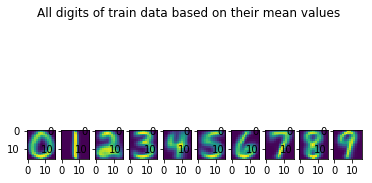

In [13]:
#function that takes y_train and returns the mean value and variance of all pixels for all digits in train set - calls function mv_var_digit
def mv_var_all_digits (y_train):
    mean_pixels_d = [None] * 10
    var_pixels_d = [None] * 10
    for label in range(0,10):
        indices_d = [i for i, x in enumerate(y_train) if x == label]
        (mean_pixels_d[label],var_pixels_d[label]) = mv_var_digit(indices_d)
    return (mean_pixels_d,var_pixels_d)

#function that takes the indices of appareance of a digit and returns the mean value and variance of all pixels for the digit in train set
def mv_var_digit (indices_d):
    pixels_d = []
    for i in indices_d:
        pixels_d.append(np.reshape(X_train[i,:], (16,16)))
    mean_pixels_d = np.mean(pixels_d,axis=0)
    var_pixels_d = np.var(pixels_d,axis=0)
    return (mean_pixels_d,var_pixels_d)

#function that takes the arrays of features for each digit and subplots them
def subplt_samples_all (rsample):
    for i in range(0,10):
        fig.add_subplot(1,10,i+1)
        plt.imshow(rsample[i])
    return
  
# mean value and variance of all pixels for all digits in train set
(mean_pixels_d,var_pixels_d) = mv_var_all_digits(y_train)

fig = plt.figure(5)
subplt_samples_all (mean_pixels_d)
fig.suptitle('All digits of train data based on their mean values')

plt.show()

# STEP 10
Για την ταξινόμηση του υπ΄αριθμόν 101 ψηφίου των test δεδομένων σε μία από τις 10 κατηγορίες (0-9) βάσει της Ευκλείδιας απόστασης υλοποιήθηκε η συνάρτηση classify_digit(features_d,mean_pixels_d) η οποία λαμβάνει τα χαρακτηριστικά ενός συγκεκριμένου δείγματος (διαστάσεων (1,256) - στην προκειμένη λαμβάνει τα X_test[101,:]) και τις μέσες τιμές όλων των ψηφίων (0,9) σε μορφή numpy πίνακα (10,256). Οι τιμές αυτές υπολογίστηκαν με την mv_var_all_digits(y_train) στο Βήμα 9α και για τη χρήση τους ως όρισμα στην συνάρτηση μετασχηματίζονται σε διαστάσεις (10,256) με την np.reshape() στο εσωτερικό του main κώδικα πριν την κλήση της συνάρτησης. Στο εσωτερικό της classify_digit(features_d,mean_pixels_d) για κάθε είδος ψηφίου (0-10) υπολογίζεται η ευκλείδια απόσταση μεταξύ των μέσων τιμών των χαρακτηριστικών του και των δοθέντων χαρακτηριστικών του δείγματος προς ταξινόμηση με τη συνάρτηση scipy.spatial.euclidean() και το αποτέλεσμα (1 τιμή) αποθηκεύεται σε μια λίστα. Από τη λίστα αυτή, που περιέχει 10 στοιχεία, υπολογίζεται με τη συνάρτηση np.argmin() η θέση του μικρότερου. Η τιμή αυτή επιστρέφεται από την classify_digit(features_d,mean_pixels_d) και αποτελεί το label του ψηφίου στο οποίο ταξινομήθηκε το δοθέν δείγμα. 

Παρατηρούμε ότι η ταξινόμηση για το συγκεκριμένο δείγμα δεν ήταν επιτυχής. Είναι λογικό ο ταξινομητής μας να έχει αστοχίες συνεπώς η αξιολόγηση θα γίνει πιο αντικειμενικά όταν υπολογιστεί το score για όλα τα δείγματα.


In [14]:
#function that classifies a given digit of test set based on the euclidean distance with mean value of each digit and return the label matched
def classify_digit (features_d,mean_pixels_d):
    eudist_d_all = []
    for i in range(0,10):
        eudist_d = distance.euclidean(features_d, mean_pixels_d[i])
        eudist_d_all.append(eudist_d)
    return (np.argmin(eudist_d_all))

# classification of the digit at index 101 of test set based on the euclidean distance with mean value of each digit (0-9) of train set
features_101 = X_test[101,:]
mean_pixels_d = np.reshape(mean_pixels_d, (10,X_train.shape[1]))
digit_matched = classify_digit(features_101,mean_pixels_d)
print("Digit 101 is classified to",float(digit_matched),"and its true value is",y_test[101])

Digit 101 is classified to 0.0 and its true value is 6.0


# STEP 11
Για την ταξινόμηση όλων των ψηφίων των test δεδομένων σε μία από τις 10 κατηγορίες με βάση την Ευκλείδια απόσταση υλοποιήθηκε η συνάρτηση classify_all(mean_pixels_d,X_test,y_test) η οποία γενικεύει τη διαδικασία που ακολουθήσαμε στο Βήμα 10 για όλα τα δείγματα του X_test. Συγκεκριμένα, η συνάρτηση αυτή παίρνει ως είσοδο τις μέσες τιμές όλων των ψηφίων (0,9), που υπολογίστηκαν με την mv_var_all_digits(y_train) στο Βήμα 9α, σε μορφή numpy πίνακα (10,256), το σύνολο των δειγμάτων του X_test και τα αντίστοιχα label τους στον y_test. Για κάθε δείγμα του X_test καλείται η συνάρτηση classify_digit(features_d,mean_pixels_d) που εξηγήθηκε στο Βήμα 10 και επιστρέφεται το label που αντιστοιχήθηκε στο συγκεκριμένο δείγμα. Το αποτέλεσμα κάθε ταξινόμησης αποθηκεύεται σε μια λίστα που περιέχει τις αντιστοιχίσεις για το σύνολο των δειγμάτων και επιστρέφεται από την classify_all(mean_pixels_d,X_test,y_test). Παράλληλα, υπολογίζεται το success rate της ταξινόμησης για το σύνολο το δειγμάτων του Χ_test ελέγχοντας απλά αν το label που αντιστοιχίθηκε είναι το ίδιο με το πραγματικό label του δείγματος στο y_test και επίσης επιστρέφεται από την classify_all(mean_pixels_d,X_test,y_test). 

Εμφανίζεται το success rate της ταξινόμησης όλων των δειγμάτων του X_test με βάσει την ευκλείδια απόσταση.

In [15]:
#function that classifies a given digit of test set based on the euclidean distance with mean value of each digit and return the label matched
def classify_digit (features_d,mean_pixels_d):
    eudist_d_all = []
    for i in range(0,10):
        eudist_d = distance.euclidean(features_d, mean_pixels_d[i])
        eudist_d_all.append(eudist_d)
    return (np.argmin(eudist_d_all))
  
#function that classifies all digit of test set based on the euclidean distance with mean value of each digit and return the labels matched and the success rate of classification
def classify_all (mean_pixels_d,X_test,y_test):
    len_samples = X_test.shape[0]
    digit_matched = [None] * len_samples
    hits_clas = 0
    for i in range(0,len_samples):
        features_d = X_test[i,:]
        digit_matched[i] = float(classify_digit(features_d,mean_pixels_d))
        hits_clas = hits_clas + (digit_matched[i] == y_test[i])
    srate_eudist = hits_clas / len_samples
    return (digit_matched,srate_eudist)

  
# classification of each digit of test set based on the euclidean distance with mean values of each digit (0-9) of train set
mean_pixels_d = np.reshape(mean_pixels_d, (10,X_train.shape[1]))
(digit_matched,srate_eudist) = classify_all(mean_pixels_d,X_test,y_test)
#print("Digits in test are classified as",digit_matched)
print("Success rate of euclidean distance classification is",srate_eudist*100,"%")

Success rate of euclidean distance classification is 81.4150473343 %


# STEP 12
Για την υλοποίηση του ταξινομητή ευκλείδιας απόστασης σαν ένα scikit-learn estimator χρησιμοποιήθηκε ως σαν βάση ο κώδικας που δόθηκε και δημιουργήθηκε μια κλάση class EuclideanClassifier(BaseEstimator, ClassifierMixin) με τις μεθόδους _init_,fit, predict και score (βρισκεται στις Παρατηρήσεις). Στο εσωτερικό των μεθόδων αυτών χρησιμοποιήσαμε τον κώδικα που γράψαμε στα προηγούμενα ερωτήματα, με εξαίρεση της _init_(self) η οποία υλοποιήθηκε όπως ακριβώς στο δοθέν παράδειγμα. 

*   Στην fit(self, X, y) υπολογίζονται οι μέσες τιμές για κάθε ψηφίο (0-9) και αποθηκεύονται στο self.X_mean_  στη μορφή numpy array (10,256).
*   Στην predict(self, X) υπολογίζονται σε μια λίστα οι προβλέψεις των labels (0-9) για κάθε δείγμα του Χ με βάση την Ευκλείδια απόσταση των χαρακτηριστικών κάθε δείγματος και του self.X_mean_ που έχει υπολογιστεί για τα 10 ψηφία.
*  Τέλος, στην score(self, X, y) καλείται η predict(self, X) και για τις προβλέψεις που επιστρέφονται γίνεται ο έλεγχος με τα πραγματικά labels y και επιστρέφεται το ποσοστό επιτυχίας. 

Στο εσωτερικό του main κώδικα δοκιμάζουμε τον scikit-learn classifier που φτιάξαμε. Συγκεκριμένα, καλούμε αρχικά τη μέθοδο fit με εισόδους τα X_train, y_train και στη συνέχεια καλούμε τη μέθοδο score με εισόδους τα X_test, y_test. 

Το ποσοστό επιτυχίας που παίρνουμε είναι ίδιο με πριν γεγονός που επιβεβαιώνει την ορθότητα του μοντέλου που υλοποιήσαμε.

In [16]:
# classifier of euclidean distance as a scikit learn learn estimator - class EuclideanClassifier
# as in STEP 11 we try to classify each digit of test set with mean values of each digit (0-9) of train set
clf = EuclideanClassifier()
clf.fit(X_train,y_train)
score = clf.score(X_test,y_test)
print("Success rate of scikit-learn Euclidean Classifier is",score*100,"%")

Success rate of scikit-learn Euclidean Classifier is 81.4150473343 %


# STEP 13 A
Για τον υπολογισμό του score του ευκλείδιου ταξινομητή με χρήση 5-fold cross-validation χρησιμοποιούμε τη συνάρτηση sklearn.model_selection.cross_val_score() με παραμέτρους το μοντέλο που υλοποιήσαμε EuclideanClassifier(), τα X_train, y_train, cv=KFold(n_splits=5, shuffle = True, random_state=100) και scoring="accuracy". Για να υπολογίσουμε το score παίρνουμε την μέση τιμή των 5 folds με την np.mean(). Επιλέγουμε να γίνεται shuffle (δηλαδή ανάμειξη του set) των δεδομένων πριν τον διαχωρισμό τους και έπειτα από κάποιες δοκιμές για το random_state επιλέγουμε αυτό που δίνει καλύτερο score.

Με τον τρόπο αυτό αποφεύγουμε το overfitting στο train set και καταλήγουμε όπως αναμέναμε σε καλύτερο score για την ταξινόμηση και με μικρές αποκλίσεις.

In [17]:
# A - calculate the score of the scikit-learn Euclidean Classifier with 5-fold cross-validation
score_crossval = cross_val_score(EuclideanClassifier(), X_train, y_train, cv=KFold(n_splits=5, shuffle = True, random_state=100), scoring="accuracy")
print("Success rate of scikit-learn Euclidean Classifier with 5-fold cross-validation is %f +-%f"%(np.mean(score_crossval)*100,np.std(score_crossval)*100),"%")

Success rate of scikit-learn Euclidean Classifier with 5-fold cross-validation is 85.036465 +-0.469976 %


# STEP 13 B
Για το σχεδιασμό της  περιοχής απόφασης (decision surface) του Ευκλείδιου ταξινομητή υλοποιήσαμε τη συνάρτηση plot_clf(clf, X_new, y_train,labels) η οποία παρουσιάστηκε στο notebook Lab 0.3 Scikit-learn.ipynb στο εργαστήριο. Για το σχεδιασμό της περιοχής απόφασης αρκεί να διαλέξουμε δύο τυχαία features. Για το λόγο αυτό, στο εσωτερικό του main κώδικα και πριν από την κλήση της συνάρτησης για το plot δημιουργούμε τον πίνακα X_new με δύο χαρακτηριστικά από το σύνολο του Χ_train (επιλέξαμε τα χαρακτηριστικά στις θέσεις 10,104). Καλούμε τη μέθοδο fit του EuclideanClassifier() που υλοποιήσαμε με εισόδους τον νέο πίνακα χαρακτηριστικών X_new και το y_train, ώστε να υπολογιστεί ο πίνακας μέσων τιμών για τα ψηφία βάσει των χαρακτηριστικών στα οποία θα γίνει η σχεδίαση. Επίσης, δημιουργούμε τη λίστα labels με τιμές από 0-9 για να αποδοθούν στην αναπαράσταση των 10 ψηφίων στη γραφική. Στο εσωτερικό της συνάρτησης plot_clf(clf, X_new, y_train,labels) σχεδιάζουμε την περιοχή απόφασης χρησιμοποιώντας το αποτέλεσμα της μεθόδου predict του EuclideanClassifier() για τα δύο χαρακτηριστικά που επιλέχθηκαν και το σύνολο των δειγμάτων. Επιπλέον αναπαριστούμε με διαφορετικά χρώματα κάθε ψηφίο στην περιοχή που βρίσκεται.

Με τα δύο τυχαία χαρακτηριστικά προκύπτει η πρώτη επιφάνεια απόφασης. Για το σχεδιασμό της επιφάνειας απόφασης κανονικά χρειαζόμαστε και τα 256 χαρακτηριστικά για να μπορέσουμε να σχολιάσουμε τις θέσεις των ψηφίων ως προς τις περιοχές που αυτά ορίζουν στην επιφάνεια. Αυτό οφείλεται στο γεγονός ότι οι τιμές των δειγμάτων κάποιου ψηφίου πιθανόν να διαφέρουν σε μεγάλο βαθμό ως προς τα δύο τυχαία χαρακτηριστικά που επιλέχθηκαν και να τοποθετούνται σε αρκετά διαφορετικά σημεία στις 2 περιοχές.

Δοκιμάζουμε, επίσης, να σχεδιάσουμε την περιοχή απόφασης χρησιμοποιώντας την τεχνική PCA για το χωρισμό των χαρακτηριστικών σε δύο συνιστώσες, για να πετύχουμε καλύτερα αποτελέσματα. Με την τεχνική αυτή μειώνουμε τις διαστάσεις, βρίσκοντας ένα νέο σύνολο χαρακτηριστικών - συνιστωσών, οι οποίες είναι σύνθετες από τα αρχικά χαρακτηριστικά, αλλά δεν συνδέονται μεταξύ τους. Η πρώτη συνιστώσα αντιπροσωπεύει τη μεγαλύτερη δυνατή διασπορά στα δεδομένα, η δεύτερη αντιπροσωπεύειτη δεύτερη μεγαλύτερη διασπορά κλπ. Προκύπτει η δεύτερη επιφάνεια απόφασης στην οποία πλέον διακρίνουμε ευκρινώς τις περιοχές ταξινόμησης όλων των ψηφίων. Ταυτόχρονα, παρατηρούμε ότι ψηφία που μοιάζουν σε χαρακτηριστικά (όπως το 4,9,8 και 5,6) καταλαμβάνουν κοντινές περιοχές.

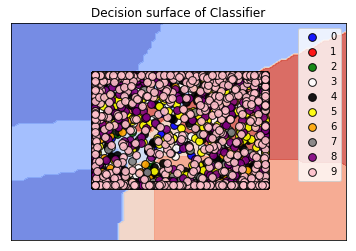

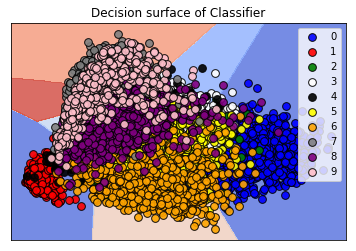

In [18]:
#function that plots the decision surface of the Euclidean Classifier
def plot_clf(clf, X, y, labels):
    fig,ax = plt.subplots()
    # title for the plots
    title = ('Decision surface of Classifier')
    # Set-up grid for plotting.
    X0, X1 = X[:, 0], X[:, 1]
    x_min, x_max = X0.min() - 1, X0.max() + 1
    y_min, y_max = X1.min() - 1, X1.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),np.arange(y_min, y_max, .05))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    colour_label = ['blue','red','green','white','black','yellow','orange','grey','purple','pink']
    for i in range(0, 10):
        ax.scatter(X0[y==i], X1[y==i],c=colour_label[i],label = labels[i],s=60, alpha=0.9, edgecolors='k')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()
    
# B - draw the decision surface of the scikit-learn Euclidean Classifier using 2 random features
X_new = X_train[:,[10, 104]]
labels = [0,1,2,3,4,5,6,7,8,9]
clf = EuclideanClassifier()
clf.fit(X_new,y_train)
plot_clf(clf, X_new, y_train,labels)
plt.show()

# draw the decision surface using PCA for better results
pca = PCA(n_components=2)
pca.fit(X_train)
X_new = pca.transform(X_train)
labels = [0,1,2,3,4,5,6,7,8,9]
clf = EuclideanClassifier()
clf.fit(X_new,y_train)
plot_clf(clf, X_new, y_train,labels)
plt.show()

# STEP 13 C
Για το σχεδιασμό της καμπύλης εκμάθησης (learning curve) του Ευκλείδιου ταξινομητή χρησιμοποιήθηκε η συνάρτηση sklearn.model_selection.learning_curve() με παραμέτρους το μοντέλο μας EuclideanClassifier(), τα X_train, y_train, cv=5, n_jobs=-1 και train_sizes=np.linspace(.2, 1.0, 5) η οποία επιστρέφει τα train_sizes, train_scores, test_scores που θα χρησιμοποιηθούν για το σχεδιασμό. Επίσης, υλοποιήσαμε την συνάρτηση plot_learning_curve(train_scores, test_scores, train_sizes, ylim=None) η οποία παρουσιάστηκε στο notebook Lab 0.3 Scikit-learn.ipynb στο εργαστήριο και η οποία με τα παραπάνω δεδομένα δημιουργεί την καμπύλη εκμάθησης και συγκεκριμένα αναπαριστά το training score και το cross validation score συναρτήσει των training examples.

Παρατηρούμε ότι με την αύξηση των training examples το Training score μειώνεται ελάχιστα ενώ το Cross - validation score αυξάνεται ελάχιστα και τείνουν να λάβουν πολύ κοντινή τιμή. Οι αποκλίσεις μεταξύ των score με την αύξηση των δειγμάτων είναι της τάξης του 1-2%.


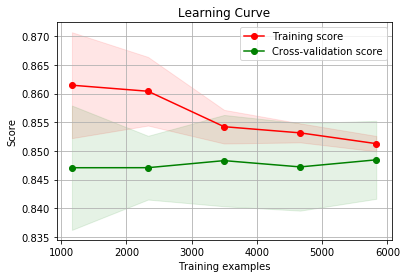

In [19]:
#function that plots the learning curve of the Euclidean Classifier

def plot_learning_curve(train_scores, test_scores, train_sizes, ylim=None):
    plt.figure()
    plt.title("Learning Curve")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# C - draw the learning curve of the scikit-learn Euclidean Classifier
train_sizes, train_scores, test_scores = learning_curve(EuclideanClassifier(), X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.2, 1.0, 5))
plot_learning_curve(train_scores, test_scores, train_sizes)

plt.show()


# STEP 14

Για τον υπολογισμό των a-priori πιθανοτήτων για κάθε κατηγορία 0-9 χρησιμοποιούμε τη συνάρτηση np.bincount() στο σύνολο των labels των δειγμάτων, η οποία μετρά των αριθμό των εμφανίσεων κάθε ετικέτας σε αυτό. Το πλήθος δειγμάτων κάθε ετικέτας διαιρείται στη συνέχεια με τον συνολικό αριθμό των δειγμάτων και το αποτέλεσμα αποτελεί την a-priori πιθανότητα για το ψηφίο. 

Εμφανίζουμε τις a-priori πιθανότητες για όλα τα ψηφία 0-9 όπως φαίνεται στη συνέχεια. Παρατηρούμε ότι δεν υπάρχουν μεγάλες αποκλίσεις στις πιθανότητες αυτές (η μεγαλύτερη απόκλιση είναι 0.1) και όλες κινούνται γύρω στην τιμή 0.1. Επιπλέον παρατηρούμε ότι το άθροισμα όλων των a-priori πιθανοτήτων είναι 1 γεγονός που επιβεβαιώνει την ορθότητα του υπολογισμών μας.

In [20]:
# calculate the a priori propabilities for each category of digit 0-9
frequencies = np.bincount(y_train.astype(int))
apriori = np.divide(frequencies,y_train.shape[0])

for i in range(0,10):
    print('Apriori of digit',i,'is',apriori[i])


Apriori of digit 0 is 0.163763544095
Apriori of digit 1 is 0.13784117405
Apriori of digit 2 is 0.100260595254
Apriori of digit 3 is 0.0902482512687
Apriori of digit 4 is 0.0894253188863
Apriori of digit 5 is 0.0762584007681
Apriori of digit 6 is 0.0910711836511
Apriori of digit 7 is 0.0884652311068
Apriori of digit 8 is 0.0743382252092
Apriori of digit 9 is 0.0883280757098


# STEP 15

Για την υλοποίηση ενός Bayesian Classifier πρακτικά θέλουμε να δημιουργήσουμε μια συνάρτηση η οποία αντιστοιχεί μια ετικέτα y = Ck για κάποια k ως εξής: 

*y = argmax{p(Ck)Πp(xi | Ck)}* για k από 1-Κ κατηγορίες και i από 1-n χαρακτηριστικά για κάθε δείγμα.

Για τον υπολογισμό του παραπάνω χρειαζόμαστε τις a-priori πιθανότητες κάθε κατηγορίας p(Ck) καθώς και τις πιθανότητες p(xi | Ck) οι οποίες μπορούν να υπολογισθούν από τη συνάρτηση πυκνότητας πιθανότητας της κανονικής κατανομής με τη βοήθεια των μέσων τιμών και διασπορών των χαρακτηριστικών (όπως υπολογίζονται στο βήμα 9α). 

Για την υλοποίηση του Bayes ταξινομητή σαν ένα scikit-learn estimator δημιουργήθηκε μια κλάση class BayesClassifier(BaseEstimator, ClassifierMixin) με τις μεθόδους _init_,fit, predict και score (βρισκεται στις Παρατηρήσεις) και μια επιπλέον μέθοδος calcGaussian(self,x,mean,var) η οποία χρησιμοποιείται στους υπολογισμούς από την predict.

*   Στο εσωτερικό της _init_(self) γίνονται αρχικοποιήσεις για τις μεταβλητές της κλάσης.
*    Στην fit(self, X, y, v) υπολογίζονται οι μέσες τιμές και  οι διασπορές για κάθε ψηφίο (0-9) και αποθηκεύονται στις μεταβλητές self.X_mean_, self.X_var_ στη μορφή numpy array (10,256) και επιπλέον υπολογίζονται οι a-priori πιθανότητες κάθε κατηγορίας οι οποίες αποθηκεύονται στην self.X_apriori_ ως λίστα 10 στοιχείων.
*   Στην predict(self, X) υπολογίζεται για κάθε δείγμα η πιθανότητα να ανήκει σε κάθε κλάση 0-9 καλώντας την μέθοδο calcGaussian(self,x,mean,var), η οποία υπολογίζει σε όλα τα χαρακτηριστικά του δείγματος τη συνάρτηση πυκνότητας πιθανότας χρησιμοποιώντας τις τιμές self.X_mean_, self.X_var_ για κάθε χαρακτηριστικό και κάθε ψηφίο 0-9. Οι τιμές επιστρέφονται ως στοιχεία μιας λίστας και πολλαπλασιάζονται μεταξύ τους και με την a-priori πιθανότητας της κλάσης. Η πρόβλεψη για κάθε δείγμα υπολογίζεται παίρνοντας την κλάση με την υψηλότερη πιθανότητα από όσες υπολογίστηκαν και επιστρέφονται σε μια λίστα οι προβλέψεις των labels (0-9) για κάθε δείγμα του Χ. 
*   Στην score(self, X, y) καλείται η predict(self, X) και για τις προβλέψεις που επιστρέφονται γίνεται ο έλεγχος με τα πραγματικά labels y και επιστρέφεται το ποσοστό επιτυχίας.

Στο εσωτερικό του main κώδικα δοκιμάζουμε τον scikit-learn classifier που φτιάξαμε. Συγκεκριμένα, καλούμε αρχικά τη μέθοδο fit με εισόδους τα X_train, y_train και στη συνέχεια καλούμε τη μέθοδο score με εισόδους τα X_test, y_test.

Επίσης καλούμε την έτοιμη υλοποίηση GaussianNB() του scikit-learn με τον ίδιο τρόπο.

Παρατηρούμε ότι τα ποσοστά που πετυχαίνουν οι δύο μέθοδοι είναι κοντά αλλά η δική μας υλοποίηση πετυχαίνει καλύτερο αποτέλεσμα κατά 6% περίπου. Από την άλλη, ο χρόνος εκτέλεσης του έτοιμου μοντέλου είναι μικρότερος του δικού μας κατά 2 sec περίπου.


In [21]:
# create a naive Bayesian Classifier as a scikit learn learn estimator - class BayesClassifier
clf = BayesClassifier()
clf.fit(X_train,y_train,0)      # 0 is used when we normally calculate the variance from X_train
score = clf.score(X_test,y_test)
print("Success rate of our scikit-learn Bayes Classifier is",score*100,"%")

# compare our Bayes Classifier with the scikit-learn GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test,y_test)
print("Success rate of imported scikit-learn GaussianNB is",score*100,"%")

Success rate of our scikit-learn Bayes Classifier is 77.4788241156 %
Success rate of imported scikit-learn GaussianNB is 71.9481813652 %


# STEP 16

Για τον υπολογισμό της ταξινόμησης Bayes υποθέτοντας ότι η διασπορά για όλα τα χαρακτηριστικά, για όλες τις κατηγορίες ισούται με 1, χρησιμοποιούμε στο μοντέλο που υλοποιήσαμε στη μέθοδο fit την παράμετρο v. Συγκεκριμένα, αν η παράμετρος v=0 τότε οι διασπορές των χαρακτηριστικών για κάθε ψηφίο υπολογίζονται κανονικά όπως έχουμε αναλύσει προηγουμένως, διαφορετικά όλες οι τιμές τίθενται στο 1. 

Στο εσωτερικό του main κώδικα καλούμε τη μέθοδο fit του Bayes classifier με εισόδους τα X_train, y_train και v=1 (ώστε να έχουμε διαπορές ίσες με 1). Στη συνέχεια καλούμε τη μέθοδο score με εισόδους τα X_test, y_test.

Παρατηρούμε αύξηση του score της μεθόδου κατά 4% περίπου. Θέτοντας τις διασπορές ίσες με 1 πρακτικά είναι σαν να ανεξαρτητοποιούμε τις πιθανότητες p(xi | Ck) (που υπολογίζονται βάσει του Gaussian distribution) από την επίδραση της διασποράς. Αντιθέτως οι μέσες τιμές είναι αυτές που, πλέον, καθορίζουν τις πιθανότητες βάσει της συνάρτησης.


In [22]:
# calculate the score of our naive Bayes classifier when variances of features of all digits are equal to 1
clf = BayesClassifier()
clf.fit(X_train,y_train,1)      # 0 is used when we normally calculate the variance from X_train
score = clf.score(X_test,y_test)
print("Success rate of our scikit-learn Bayes Classifier with variances 1 is",score*100,"%")

Success rate of our scikit-learn Bayes Classifier with variances 1 is 81.2655705032 %


# STEP 17

Θα συγκρίνουμε την επίδοση των Naive Bayes ταξινομητών (του δικού μας και του έτοιμου GaussianNB()) των οποίων τις επιδόσεις τυπώσαμε παραπάνω με τους Nearest Neighbors, SVM. Καλούμε τις  μεθόδους fit, score των KNeighborsClassifier() με k=5 και svm.SVC() με kernel = 'rbf', kernel = 'linear' και kernel = 'poly'. Παρατηρούμε ότι και οι δύο αυτοί ταξινομητές εμφανίζουν πολύ μεγαλύτερα ποσοστά επιτυχίας από τους Bayes classifiers που μελετήσαμε προηγουμένως, προσεγγίζοντας το 95%. Το μεγαλύτερο ποσοστό εμφανίζεται στον svm classifier με kernel = 'poly' ενώ ακολουθεί ο KNeighbors.

Το μοντέλο των k πλησιέστερων γειτόνων επιτυγχάνει σταθερά υψηλές επιδόσεις, χωρίς a priori υποθέσεις σχετικά με τις κατανομές από τις οποίες χαρακτηρίζονται τα δείγματα του training set. Από την άλλη το μοντέλο είναι υπολογιστικά πολύ εξαντλητικό, καθώς για κάθε δείγμα ο αλγόριθμος διατρέχει όλα τα δεδομένα για να βρει τον κοντινότερο γείτονα. Ένα νέο δείγμα ταξινομείται βάσει του υπολογισμού της απόστασης από τα χαρακτηριστικά τoυ κοντινότερου δείγματος. Η μετρική που χρησιμοποιείται by default για την απόσταση είναι η minkowski με p=2 που ισοδυναμεί με την Euclidean απόσταση. Ο k-NN ταξινομητής επεκτείνει την παραπάνω ιδέα παίρνοντας τα k πλησιέστερα σημεία και αποφασίζοντας βάσει της πλειοψηφίας από την ψήφο των γειτόνων. Συνήθως επιλέγονται 1, 3 ή 5 γείτονες, ενώ υψηλότερες τιμές μπορεί να οδηγήσουν σε overfitting. Επιπλέον, το μοντέλο δεν αποδίδει καλά σε imbalanced data, κάτι που δεν συμβαίνει στην ερίπτωση μας μιας και έχουμε παρόμοιο αριθμό δειγμάτων σε κάθε κατηγορία.

Το μοντέλο Support Vector Machine προσπαθεί να βρει το βέλτιστο υπερεπίπεδο για το διαχωρισμό των διάφορων κλάσεων, μεγιστοποιώντας την απόσταση μεταξύ των σημείων που αντιστοιχούν σε κάθε δείγμα στον χώρο των χαρακτηριστικών και του υπερεπιπέδου. Η παράμετρος kernel προσδιορίζει το είδος του υπερεπιπέδου που χρησιμοποιείται για να διαχωρίσει τα δεδομένα. Το συγκεκριμένο μοντέλο είναι αποτελεσματικό σε χώρους με μεγάλες διαστάσεις, ενώ χρησιμοποιεί ένα υποσύνολο των σημείων του training set στη συνάρτηση απόφασης (που ονομάζονται support vectors), επομένως είναι επίσης αποδοτικό στη μνήμη.



In [23]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# compare scores of scikit-learn Naive Bayes, Nearest Neighbors, SVM classifiers
clf_gauss = GaussianNB()
temp = clf_gauss.fit(X_train, y_train)
score1 = clf_gauss.score(X_test, y_test)

clf_kneigh = KNeighborsClassifier()
clf_kneigh.fit(X_train, y_train)
score2 = clf_kneigh.score(X_test,y_test)

clf_rbf = svm.SVC(probability = True, random_state=72)
clf_rbf.fit(X_train, y_train)
score3 = clf_rbf.score(X_test,y_test)

clf_linear = svm.SVC(kernel='linear', probability = True, random_state=72)
clf_linear.fit(X_train, y_train)
score4 = clf_linear.score(X_test,y_test)

clf_poly = svm.SVC(kernel='poly', probability = True, random_state=72)
clf_poly.fit(X_train, y_train)
score5 = clf_poly.score(X_test,y_test)

print("Success rate of scikit-learn GaussianNB is",score1*100,"%")
print("Success rate of scikit-learn KNeighborsClassifier is",score2*100,"%")
print("Success rate of scikit-learn svm with kernel='rbf' is",score3*100,"%")
print("Success rate of scikit-learn svm with kernel='linear' is",score4*100,"%")
print("Success rate of scikit-learn svm with kernel='poly' is",score5*100,"%")


Success rate of scikit-learn GaussianNB is 71.9481813652 %
Success rate of scikit-learn KNeighborsClassifier is 94.4693572496 %
Success rate of scikit-learn svm with kernel='rbf' is 94.2202291978 %
Success rate of scikit-learn svm with kernel='linear' is 92.6258096662 %
Success rate of scikit-learn svm with kernel='poly' is 94.6686596911 %


# STEP 18 Α

Παρατηρώντας τα confusion matrices κάθε classifier από τo προηγούμενo ερώτημα, επιλέγουμε για να εφαρμόσουμε ensembling τους ταξινομητές SVM με kernel linear, SVM με kernel poly και KNeighborsClassifier. Αυτό το κάνουμε γιατί οι ταξινομητές που θα συνδυαστούν θέλουμε να χαρακτηρίζονται από διαφορετικό τύπο λαθών και ταυτόχρονα να παρουσιάζουν καλά ποσοστά στην ταξινόμηση ώστε να πετύχουμε κάτι υψηλότερο μέσω του συνδυασμού τους. Είναι αναγκαίο να επιλεχθεί μονός αριθμός ταξινομητών, ώστε να είναι δυνατή η επίτευξη απόλυτης πλειοψηφίας.

Ο VotingClassifier στον συνδυασμό με hard voting προβλέπει το label βάσει της πλειοψηφίας της ψηφοφορίας, ενώ στο soft voting βάσει του argmax των αθροισμάτων των προβλεπόμενων πιθανοτήτων. Καθώς το soft voting προτείνεται κυρίως σε σύνολα καλά βαθμονομημένων ταξινομητών και οι confusion matrices δεν παρουσιάζουν μεγάλες αποκλίσεις, τα ποσοστά επιτυχίας για hard και soft είναι καλύτερα από το ερώτημα 17 και παρόμοια μεταξύ τους. Επίσης, δοκιμάσαμε μεταβολές στα βάρη κάθε ταξινομητή στο ensembling με hard voting δίνοντας λίγο παραπάνω στον svm(kernel='poly') και στον KNeighbors που κάνουν ορθότερα predictions. Οι βελτιώσεις είναι μικρές. Στην περίπτωση του soft παρατηρήσαμε ότι δεν προσφέρουν βελτίωση και δεν τα συμπεριλάβαμε. 

In [24]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

weights = [1, 2, 2]
#voting classifier of SVM poly, SVM linear and KNeighbors with hard voting
eclf1 = VotingClassifier(estimators=[('linear', clf_linear), ('KNeighborsClassifier', clf_kneigh), ('poly', clf_poly)], voting='hard', weights=weights)
eclf1 = eclf1.fit(X_train, y_train)
score_eclf1 = eclf1.score(X_test, y_test)
print("Success rate of hard VotingClassifier is", score_eclf1*100,"%")

#voting classifier of SVM poly, SVM linear and KNeighbors with soft voting
eclf2 = VotingClassifier(estimators=[('linear', clf_linear), ('KNeighborsClassifier', clf_kneigh), ('poly', clf_poly)], voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
score_eclf2 = eclf2.score(X_test, y_test)
print("Success rate of soft VotingClassifier is", score_eclf2*100,"%")

Success rate of hard VotingClassifier is 95.067264574 %
Success rate of soft VotingClassifier is 94.9177877429 %


# STEP 18 Β

Δοκιμάζοντας τον Bagging Classifier με base estimator κάθε φορά έναν από τους ταξινομητές που δοκιμάσαμε παραπάνω, παρατηρήσαμε ότι στις περισσότερες περιπτώσεις οδηγούμασταν σε ελάχιστα καλύτερο score μετά το ensembling, σε σχέση με τα score των ταξινομητών (ερώτημα 17), ακόμη και έπειτα από tuning στην παράμετρο του πλήθους των estimators και του πλήθους των δειγμάτων.

Στην τεχνική του bagging υπάρχει ένα trade-off μεταξύ της ακρίβειας του base estimator και του κέρδους που επιτυγχάνετε μέσω του bagging. Το aggregation που πραγματοποιείται στο bagging μπορεί να βελτιώσει σημαντικά το σύνολο, όταν έχουμε ένα ασταθές μοντέλο, αλλά όταν τα βασικά μας μοντέλα είναι πιο σταθερά - έχουν εκπαιδευτεί σε περισσότερα δείγματα με μεγαλύτερη ακρίβεια - οι βελτιώσεις μειώνονται.

Επιλέξαμε λοιπόν ως Base estimator τον svm με kernel='linear' classifier που κάνει αποτελεσματική ταξινόμηση, αλλά δεν εμφανίζει το καλύτερο score από όλους τους παραπάνω, γιατί εμφάνιζε πιο αισθητές βελτιώσεις μέσω της τεχνικής. Κάνοντας tuning στις παραμέτρους επιλέξαμε πλήθος estimators ίσο με 9 και βρήκαμε το παρακάτω βελτιωμένο ποσοστό σε σχέση με το κανονικό ποσοστό του classifier.

Τέλος, θέτοντας max_samples=0.6492 χρησιμοποιούμε ουσιαστικά το 64.92% των δειγμάτων για την εκπαίσδευση κάθε estimator. Παρατηρούμε από τους παρακάτω χρόνους εκτέλεσης ότι παρόλο τον περιορισμό τον max_samples, το ποσοστό επιτυχίας είναι σχεδόν ίδιο, ενώ ο χρόνος παρουσιάζει σημαντική μείωση.

In [25]:
# BaggingClassifier with base estimator svm kernel='linear' with max samples restriction
%time clf_bagging = BaggingClassifier(base_estimator=svm.SVC(kernel='linear'), n_estimators=9, random_state=762, max_samples=0.6492).fit(X_train, y_train)
print("Success rate of BaggingClassifier with base estimator svm kernel='linear' with max_samples is", clf_bagging.score(X_test, y_test)*100, "\n")

# BaggingClassifier with base estimator svm kernel='linear' without max samples restriction
%time clf_bagging = BaggingClassifier(base_estimator=svm.SVC(kernel='linear'), n_estimators=9, random_state=762).fit(X_train, y_train)
print("Success rate of BaggingClassifier with base estimator svm kernel='linear' is", clf_bagging.score(X_test, y_test)*100)


CPU times: user 4.52 s, sys: 7.99 ms, total: 4.53 s
Wall time: 4.53 s
Success rate of BaggingClassifier with base estimator svm kernel='linear' with max_samples is 93.6223218734 

CPU times: user 6.72 s, sys: 7.93 ms, total: 6.73 s
Wall time: 6.73 s
Success rate of BaggingClassifier with base estimator svm kernel='linear' is 93.6721474838
